In [131]:
import torch
from typing import Callable
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

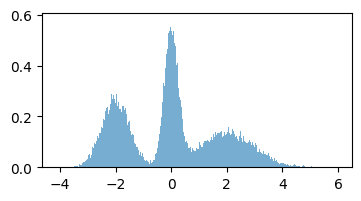

In [132]:
mixture = torch.Tensor([1, 1, 1])
loc = torch.Tensor([-2, 0, 2])
scale = torch.Tensor([0.5, 0.25, 1])
data_dist = torch.distributions.mixture_same_family.MixtureSameFamily(
    torch.distributions.Categorical(mixture), torch.distributions.Normal(loc, scale)
)
samples = data_dist.sample(torch.Size([50000])).numpy()
plt.figure(figsize=(4,2))
plt.hist(samples, bins=500, density=True, alpha=0.6)
plt.show()

# Training

In [133]:
N_TRAINING_RUNS = 4
def plot_losses(loss_histories: list[list[np.ndarray]]):
    fig, axes = plt.subplots(1, N_TRAINING_RUNS, figsize=(4 * N_TRAINING_RUNS, 3), squeeze=False)
    for i, losses in enumerate(loss_histories):
        ax = axes[0][i]
        ax.plot(losses)
        ax.set_title(f"Run {i}")
        ax.set_xlabel("Batch")
        ax.set_ylabel("Loss")
    plt.tight_layout()
    plt.show()

In [156]:
def model_and_optimizer(lr=0.00025):
    model = torch.nn.Sequential(
        torch.nn.Linear(2, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 1),
    )
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    return model, optimizer

## Learning denoiser ($\eta_z$)
In most places this is called $\hat{\epsilon}$. Learning this is equivalent to learning the score, up to a time-dependent factor. (Theorem 2.8.)

For spatially-linear one-sided interpolants, where we start from Gaussian noise and interpolate with some $x_t = \alpha(t) z + \beta(t) x_1$, the denoiser alone can also be used to construct the velocity field. (Eq. 6.7.)

(Folloinwg the notation from Stochasitc Interpolants, here $x_1$ means a ground-truth data sample, not a noise sample.)

The training objectives in SI are just MSE (as in other diffusion/score-matching/flow-matching works). We can rewrite the SI denoising loss (Eq. 6.6) like so:
\begin{align*}
\hat{L}_{\eta_z}(\hat{\eta}_z, x_t) &= \frac{1}{2} \left|\hat{\eta}_z(t,x_t)\right|^2 - \hat{\eta}_z(t,x_t)\cdot z \\
&= \frac{1}{2} \left( \left|\hat{\eta}_z(t,x_t)\right|^2 - 2\hat{\eta}(t,x_t)\cdot z + |z|^2\right) - \frac{1}{2}|z|^2 \\
&= \frac{1}{2} |\hat{\eta}_z(t, x_t) - z|^2 - \frac{1}{2}|z|^2
\end{align*}
Since $z$ is a constant w.r.t. the model, this gives the same training signal as $\frac{1}{2} |\hat{\eta}_z(t, x_t) - z|^2$, which is just $\frac{1}{2}$ the MSE between the predicted and true noise.

In [157]:
def train_denoiser(alpha: Callable, beta: Callable, model: torch.nn.Module, optimizer: torch.optim.Optimizer, input_dist: torch.distributions.Distribution, batches, batch_size):
    loss_history = []
    for _ in tqdm(range(batches)):
        optimizer.zero_grad()
        t, z, x1 = torch.rand((batch_size)), torch.randn((batch_size)), input_dist.sample(torch.Size([batch_size]))
        xt = alpha(t) * z + beta(t) * x1
        pred = model(torch.stack((t, xt)).T)
        loss = torch.nn.functional.mse_loss(pred, z.unsqueeze(1), reduction="mean")
        loss.backward()
        optimizer.step()
        loss_history.append(loss.detach().numpy())
    return loss_history

### Variance-preserving schedule (as in DDPM)
$x_t$ in DDPM is $\sqrt{\bar{\alpha}_t}x_1 + \sqrt{1-\bar{\alpha}_t}z$. (This is a different "$\alpha$" than in SI.) Replacing $\sqrt{\bar{\alpha}_t}$ with $t$ gives us this:

In [263]:
def vp_alpha(t):
    return (1 - t ** 2) ** 0.5
def vp_beta(t):
    return t

In [159]:
batches = 3_000
batch_size = 8_192

total_loss = 0
loss_histories = []

best_loss = 2**32
best_denoiser_vp_model = None

for _ in range(N_TRAINING_RUNS):
    denoiser_vp_model, denoiser_vp_optimizer = model_and_optimizer()
    hist = train_denoiser(vp_alpha, vp_beta, denoiser_vp_model, denoiser_vp_optimizer, data_dist, batches, batch_size)
    loss_histories.append(hist)
    total_loss += hist[-1]
    if hist[-1] < best_loss:
        best_loss = hist[-1]
        best_denoiser_vp_model = denoiser_vp_model

print(f"Average loss {total_loss / N_TRAINING_RUNS} over {N_TRAINING_RUNS} runs")

100%|██████████| 3000/3000 [00:09<00:00, 306.20it/s]

Average loss 0.4703235328197479 over 4 runs


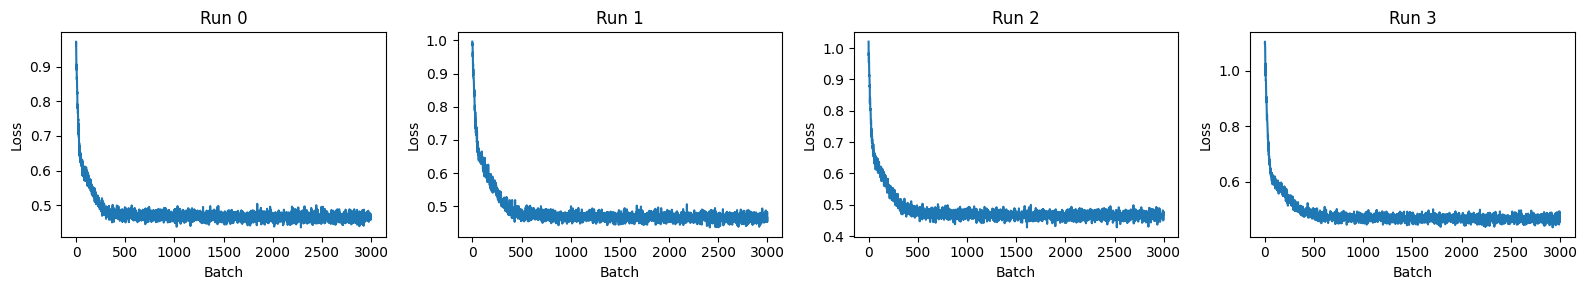

In [160]:
plot_losses(loss_histories)

## Learning drift ($b$)
If we only want to sample deterministically, we only need to learn the drift $b$. This is the technique used in Flow Maching; here we demonstrate with rectified flow, so we don't need to include noise as the noise scale $\gamma(t)$ is always 0.

The training objective for drift (Eq. 6.1) in this case is again just MSE:
\begin{align*}
\hat{L}_b(\hat{b}, x_t) &= \frac{1}{2}\left| \hat{b}(t, x_t)^2 \right| - \hat{b}(t, x_t) \cdot \left( \partial_t I(t, x_0, x_1) + \dot{\gamma}(t)z \right) \\
&= \frac{1}{2}\left| \hat{b}(t, x_t)^2 \right| - \hat{b}(t, x_t) \cdot \partial_t I(t, x_0, x_1) \\
&= \frac{1}{2}\left( \left| \hat{b}(t, x_t)^2 \right| - 2\hat{b}(t, x_t) \cdot \partial_t I(t, x_0, x_1) + \left|\partial_t I(t, x_0, x_1)\right|^2 \right) - \frac{1}{2} \left|\partial_t I(t, x_0, x_1)\right|^2 \\
&= \frac{1}{2}\left| \hat{b}(t, x_t) - \partial_t I(t, x_0, x_1)\right|^2 - \frac{1}{2} \left|\partial_t I(t, x_0, x_1)\right|^2
\end{align*}

In [244]:
def train_drift(I: Callable, pdIdt: Callable, model, optimizer: torch.optim.Optimizer, input_dist: torch.distributions.Distribution, batches, batch_size):
    global sse, n
    loss_history = [0] * batches
    for i in tqdm(range(batches)):
        optimizer.zero_grad()
        t, x0, x1 = torch.rand((batch_size)), torch.randn((batch_size)), input_dist.sample(torch.Size([batch_size]))
        xt = I(t, x0, x1)
        pred = model(torch.stack((t, xt)).T)
        loss = torch.nn.functional.mse_loss(pred, pdIdt(t, x0, x1).unsqueeze(1), reduction="mean")
        loss.backward()
        optimizer.step()
        loss_history[i] = loss.detach().item()
    return loss_history

In [245]:
def rf_I(t, x0, x1):
    return (1 - t) * x0 + t * x1
def rf_pdIdt(t, x0, x1):
    return x1 - x0
# TODO Maybe: implement this later. max=10.0 is way too low but the weighted loss variance is way too high with max=100.0
def rf_loss_weighting(t): 
    return torch.clamp((1 / (t * (1 - t))), max=10.0).to(t.dtype).to(t.device)

In [247]:
batches = 5_000
batch_size = 8_192

total_loss = 0
loss_histories = []

best_loss = 2**32
best_rf_model = None

for _ in range(N_TRAINING_RUNS):
    rf_model, rf_optimizer = model_and_optimizer()
    hist = train_drift(rf_I, rf_pdIdt, rf_model, rf_optimizer, data_dist, batches, batch_size)
    loss_histories.append(hist)
    total_loss += hist[-1]
    if hist[-1] < best_loss:
        best_loss = hist[-1]
        best_rf_model = rf_model

print(f"Average loss {total_loss / N_TRAINING_RUNS} over {N_TRAINING_RUNS} runs")

100%|██████████| 5000/5000 [00:17<00:00, 279.79it/s]

Average loss 2.6744027733802795 over 4 runs


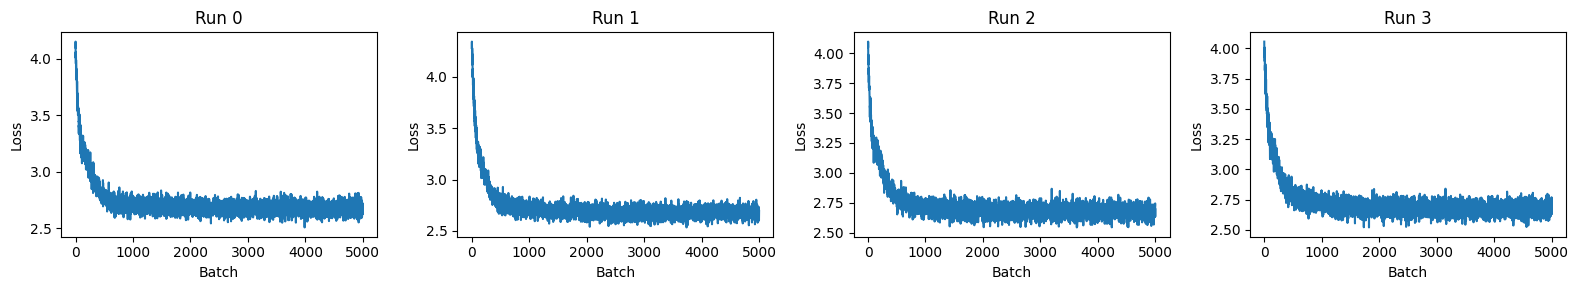

In [248]:
plot_losses(loss_histories)

# Sampling

In [344]:
N_SAMPLES = 50_000
N_STEPS_LIST = [2, 5, 10, 20, 50, 100, 250, 500, 1000]

def val_loss(pred):
    return -data_dist.log_prob(pred).mean()

# Two graphs: left graph is NLL vs number of sampling steps, 
# right graph is distribution from highest number of sampling steps
def evaluate(sample_func: Callable, model, n_steps_list = N_STEPS_LIST, n_samples = N_SAMPLES):
    nll_list, samples_list = [], []
    best_nll, best_samples = 2**31, None
    with torch.inference_mode():
        for n_steps in n_steps_list:
            samples = sample_func(n_samples, n_steps, model)
            nll_list.append(val_loss(samples))
            samples_list.append(samples)
            if nll_list[-1] < best_nll:
                best_nll, best_samples = nll_list[-1], samples

    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].scatter(n_steps_list, nll_list)
    axes[0].set_xscale('log')
    axes[0].set_xlabel("n_steps")
    axes[0].set_ylabel("Negative log likelihood")
    
    axes[1].hist(best_samples, bins=500, density=True, alpha=0.6)
    axes[1].set_xlabel("Sample value")
    axes[1].set_ylabel("Density")
    
    plt.tight_layout()
    plt.show()
    
    print(f"Best NLL {min(nll_list)}")
    
    return samples_list, nll_list

### Euler method with ODE (Rectified Flow)

In [345]:
def sample_from_drift(n_samples: int, n_steps: int, drift):
    t = 0
    x = torch.randn(n_samples)
    dt = 1 / n_steps
    while t < 1:
        b = drift(torch.stack((t * torch.ones(n_samples), x)).T).squeeze(1)
        x = x + dt * b
        t = t + dt
    return x

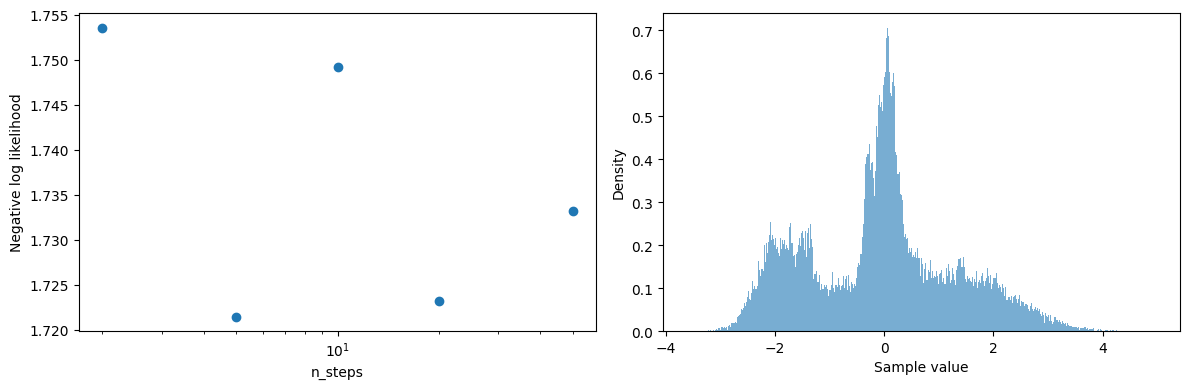

Best NLL 1.7214590311050415


In [347]:
_, _ = evaluate(sample_from_drift, best_rf_model, n_steps_list=N_STEPS_LIST[:-4])

### DDPM Sampling (Kinda)
The DDPM sampling step can be viewed both as ancestral sampling from the graphical model $p_\theta(\mathbf{x}_{t-1}|\mathbf{x}_t)$ and as Langevin dynamics sampling. In the DDPM paper (and DDPM notation), the formula used is $$x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right) + \sigma_t z$$

A few things have to change to translate this to SI notation:
- Time has to be flipped and rescaled. When we denoise in the DDPM sampling process, $t$ decreases from $T$ to $1$. When we do this in SI, $t$ increases from $0$ to $1 - \frac{1}{T}$, with $T=$`N_STEPS`.
- $\epsilon_\theta$ is the learned noise given $x_t$ and $t$, which is exactly our denoiser $\hat\eta_z$. 
- DDPM does its forward sampling (in DDPM notation) with $x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\epsilon$ while our SI forward sampling (in SI notation) is done with $x_t = \alpha(t)z + \beta(t)x_1$. The $\sqrt{\bar{\alpha}_t}$ in DDPM notation thus corresponds to $\beta(t)$ in SI notation, so we replace $\sqrt{1 - \bar{\alpha}_t}$ with $\sqrt{1 - \sqrt{\bar{\alpha}_t}^2} = \sqrt{1 - \beta(t)^2}$.

Translating $\alpha_t$ is weirder. (This is somewhat vibe math and I'm not 100% sure if it's correct.) In DDPM notation, $\alpha_t = 1 - \beta_t$, where $\beta_t$ is the variance of the Gaussian noise part of $x_t | x_{t-1}$. In our (reversed time) SI notation, the variance of the Gaussian noise at $x_{t + \frac{1}{T}}$ is $\alpha(t + \frac{1}{T})$ and increases to $\alpha(t)$ at $x_t$. So, DDPM's $\beta_t$ kinda does the same thing as $\alpha(t) - \alpha(t + \frac{1}{T})$, in that it's the increase in the variance of the Gaussian noise we add to the previous step's value. We can then get DDPM's $\alpha_t$ with $\alpha_t = 1 - \beta_t$.

Lastly, the DDPM paper says $\sigma_t = \sqrt{\beta_t}$ gives good results, so I use that. (Might be suboptimal.)

In [348]:
def sample_ddpm(n_samples: int, n_steps: int, denoiser, alpha: Callable, beta: Callable):
    t = 0
    x = torch.randn(n_samples)
    dt = 1 / n_steps
    while t < 1 - dt / 2:
        z = torch.randn(n_samples)
        ddpm_beta_t = alpha(t) - alpha(min(t + dt, 1))
        ddpm_alpha_t = 1 - ddpm_beta_t
        sigma_t = ddpm_beta_t ** 0.5
        denoiser_input = torch.stack((t * torch.ones(n_samples), x)).T
        
        x = 1 / (ddpm_alpha_t ** 0.5) * (x - \
                (1 - ddpm_alpha_t) / ((1 - beta(t) ** 2) ** 0.5) \
                * denoiser(denoiser_input).squeeze(1)) \
            + sigma_t * z
        t += dt
    return x

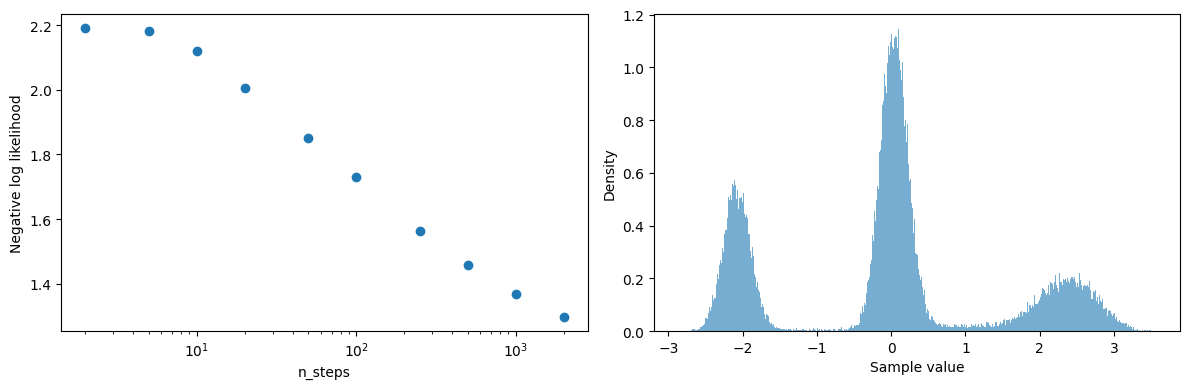

Best NLL 1.2977405786514282


In [349]:
def sample_ddpm_vp(n_samples, n_steps, denoiser):
    return sample_ddpm(n_samples, n_steps, denoiser, vp_alpha, vp_beta)
_, _ = evaluate(sample_ddpm_vp, best_denoiser_vp_model, n_steps_list=N_STEPS_LIST+[2000])

### Deterministic DDIM
(In DDIM/DDPM notation:) The DDIM sampling step works by first predicting the clean ground-truth sample $x_0$, then predicting $x_{t-1}$ using $x_t$ and this predicted $x_0$. When trained the same way as DDPM, a model sampled with the DDIM reverse process can use fewer steps to reach the same sample quality. In DDIM notation, the reverse step is described as:
$$
x_{t-1} = \sqrt{\alpha_{t-1}} \left( \frac{x_t - \sqrt{1 - \alpha_t}\epsilon_\theta^{(t)}(x_t)}{\sqrt{\alpha_t}} \right) + \sqrt{1 - \alpha_{t-1} - \sigma_t^2} \cdot \epsilon_\theta^{(t)}(x_t) + \sigma_t\epsilon_t
$$
$\alpha_t$ in the DDIM paper means the same thing as $\bar{\alpha}_t$ in DDPM, which is $\beta(t)^2$ in SI notation. Other than that, the notation is the same as in DDPM.
$\sigma_t$ can be chosen arbitrarily for different generation processes. We use $\sigma_t=0$ here for simplicity; this results in deterministic sampling.

In [374]:
def sample_ddim_det(n_samples: int, n_steps: int, denoiser, beta: Callable):
    x = torch.randn(n_samples)
    dt = 1 / (n_steps + 1)
    # t = 0 causes divide-by-zero error beacuse sqrt(ddim_alpha_t) = beta(t) = t in denominator
    # start from small positive number instead
    t = max(4e-3, dt / 50)
    while t < 1 - dt / 2:
        ddim_alpha_t, ddim_next_alpha_t = beta(t) ** 2, beta(min(1, t + dt)) ** 2
        denoiser_input = torch.stack((t * torch.ones(n_samples), x)).T
        ddim_epsilon_theta = denoiser(denoiser_input).squeeze(1)
        pred_x1 = (x - ((1 - ddim_alpha_t) ** 0.5) * ddim_epsilon_theta) / (ddim_alpha_t ** 0.5)
        x = (ddim_next_alpha_t ** 0.5) * pred_x1 \
            + ((1 - ddim_next_alpha_t) ** 0.5) * ddim_epsilon_theta
        t += dt
    return x

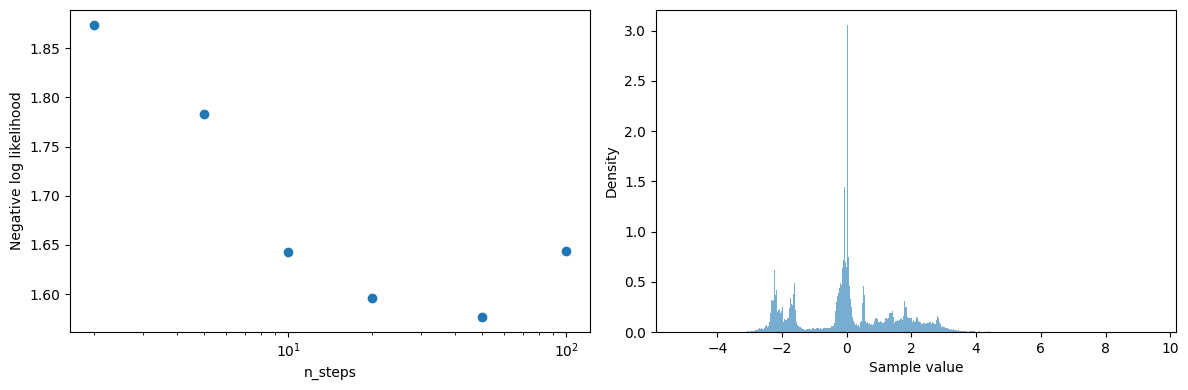

Best NLL 1.5762125253677368


In [375]:
def sample_ddim_det_vp(n_samples, n_steps, denoiser):
    return sample_ddim_det(n_samples, n_steps, denoiser, vp_beta)
_, _ = evaluate(sample_ddim_det_vp, best_denoiser_vp_model, n_steps_list=N_STEPS_LIST[:-3])

### Euler-Maruyama (Broken)

In [271]:
def sample_from_denoiser_em(n_samples: int, n_steps: int, denoiser, 
                            epsilon: Callable, alpha: Callable, beta: Callable, dalpha_dt: Callable, dbeta_dt: Callable):
    t = 0
    dt = 1 / n_steps
    x = torch.randn(n_samples)
    def get_drift(x, t):
        denoiser_input = torch.stack((t * torch.ones(n_samples), x)).T
        eta = denoiser(denoiser_input).squeeze(1)
        s = -eta / alpha(t)
        b_deterministic = dalpha_dt(t) * eta + dbeta_dt(t) / beta(t) * (x - alpha(t) * eta)
        return b_deterministic + epsilon(t) * s
    while t < 1:
        z = torch.randn_like(x)
        b = get_drift(x, t)
        x = x + dt * b + (2 * epsilon(t) * dt) ** 0.5 * x
        t = t + dt
    return x

In [272]:
def d_vp_alpha_dt(t):
    return -t / torch.sqrt(1 - torch.pow(t, 2))
def d_vp_beta_dt(t):
    return torch.ones_like(t)

In [ ]:
def sample_em_vp(n_samples, n_steps, denoiser):
    return sample_from_denoiser_em(n_samples, n_steps, denoiser, epsilon)
_, _ = evaluate(sample_ddpm_vp, best_denoiser_vp_model, n_steps_list=N_STEPS_LIST+[2000])

In [90]:
denoiser_samples = sample_from_denoiser(N_SAMPLES, N_STEPS, denoiser_vp_model, 0, vp_alpha, vp_beta, d_vp_alpha_dt, d_vp_beta_dt)